In [38]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras import callbacks

#Plot Images
import matplotlib.pyplot as plt



## Check what size images are in each folder

In [2]:
# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root= 'critter_data/Cephalaspidea/'

imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root+f)
 


In [7]:
# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head() 



Total Nr of Images in the dataset: 489


FileName        Size  Width  Height  Aspect Ratio
0                   Untitled 14 2.jpg  (261, 422)    261     422          0.62
1                   Untitled 51 2.jpg  (282, 176)    282     176          1.60
2  medium - 2022-11-28T125616.879.jpg  (500, 281)    500     281          1.78
3  medium - 2022-11-28T125526.413.jpg  (332, 500)    332     500          0.66
4                      03902ieowk.jpg  (171, 250)    171     250          0.68

Text(0, 0.5, 'Height')

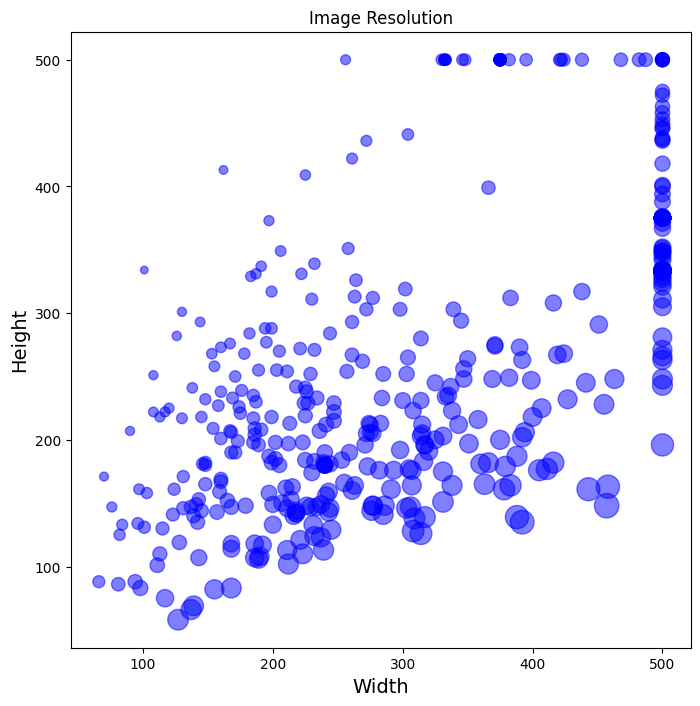

In [8]:

# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)


## Read each image and create a label for each with the name of the folder 

In [43]:

folder_dir = 'critter_data'
data = []
label = []

SIZE = 150 #Crop the image to between 128-300 (300x300) to begin, designated by below visualization

# set up labels from the name of each training photo folder
for folder in os.listdir(folder_dir):
    #ignore .DS_Store
    if not folder.startswith('.'):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                # get jpegs 
                if not file.startswith('.'):
                    if file.endswith("jpg"):
                        #label with the folder name 
                        label.append(folder)
                        img = cv2.imread(os.path.join(folder_dir, folder, file))
                        # make images black and white for model to focus on shapes
                        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        im = cv2.resize(img_grey, (SIZE,SIZE))
                        data.append(im)
                    else:
                        continue

                        

libpng warning: iCCP: extra compressed data


In [4]:
# Now, I believe the data and labels are correctly formed 
len(label) == len(data)

True

### Convert image data to numpy arrays

In [44]:
data_arr = np.array(data)
label_arr = np.array(label)

In [21]:
data_arr.shape

(2983, 150, 150, 3)

### Label encoder to normalize data 

In [56]:
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,5)
# scale data (0-1)
X = data_arr/255



### Split data into 80% train, 20% test 

(2386, 150, 150, 3)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

## Construct nueral network for species recognition 

In [24]:
# Use a sequential model because each layer has one input tensor (np.array) and one output tensor 
model = Sequential()

# implement simple Convolutional Neural Network (CNN) with Conv2D and 64 filters 
# kernel_size specifying the width and height of the 2D convolution window
# chose 3 beacause input images size = 128 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))

# filters: Layers early in the network architecture (i.e., closer to the actual input image) 
# learn fewer convolutional filters while layers deeper in the network 
# (i.e., closer to the output predictions) will learn more filters.

# Max pooling is used to reduce the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2,2)))

# padding = same so that the output volume size matches the input volume size
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

# converting multi-dimensional array into one dimensional flatten array or say single dimensional array
model.add(Flatten())

# Dense Layer is used to classify image based on output from convolutional layers.
model.add(Dense(128, activation='relu'))
# Each Layer in the Neural Network contains neurons, which compute the weighted average of its input and this weighted average is passed through a non-linear function, called as an “activation function”.
# in this case, activation function = relu 
model.add(Dense(64, activation='relu'))

# randomly selected neurons (50%) are ignored during training. They are “dropped out” randomly
# (prevent overfitting on the training data)
model.add(Dropout(rate=0.5))

#Softmax is an activation function that scales numbers/logits into probabilities. The output of a Softmax is a vector (say v ) with probabilities of each possible outcome. 
model.add(Dense(5, activation = "softmax"))



2022-11-30 13:12:37.263472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create more training images to prevent overfitting

In [25]:
# ImageDataGenerator: getting the input of the original data and further, it makes the transformation of this 
# data on a random basis and gives the output resultant containing only the data that is newly transformed. 
# This will help to avoid overfitting by generating randomly altered training photos 

gen_data = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

gen_data.fit(X_train)


### Compile/train the model 

In [26]:
# use adam optimizer algorithm for optimization technique for gradient descent
# loss= cat_cross: Used as a loss function for multi-class classification model where there are two or more output labels
# metrics= accuracy: Calculates how often predictions equal labels
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32
epochs= 64




In [28]:


# Stop training when a monitored metric has stopped improving
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


# Train the Model 

In [29]:
history = model.fit_generator(gen_data.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 1,
                              validation_data = (X_test,y_test),
                              callbacks= [earlystopping],
                              verbose = 1)

/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


75/75 [==============================] - 890s 12s/step - loss: 1.6107 - accuracy: 0.2842 - val_loss: 1.4923 - val_accuracy: 0.3719


## Evaluate the Model

In [30]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.49226713180542
Test accuracy: 0.37185928225517273


## Evaluate the Model

## Create a matrix of the Model output 

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [64]:
y_pred=model.predict(X_test)

# reshape output data 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)


ValueError: in user code:

    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)


NameError: name 'y_pred' is not defined

In [37]:
cf_matrix.shape

(5, 5)

## Plot the confusion matrix

In [39]:
import seaborn as sns

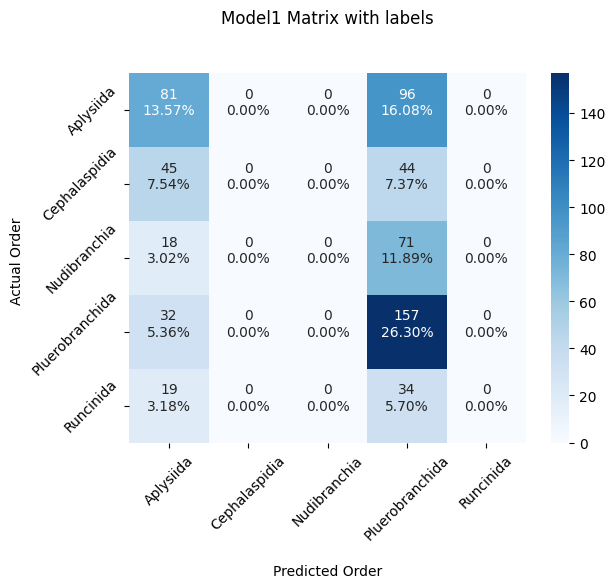

In [45]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Model1 Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Order')
ax.set_ylabel('Actual Order ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Aplysiida','Cephalaspidia', 'Nudibranchia', 'Pluerobranchida', 'Runcinida'])
ax.yaxis.set_ticklabels(['Aplysiida','Cephalaspidia', 'Nudibranchia', 'Pluerobranchida', 'Runcinida'])

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt

data= 

ax = seaborn.heatmap(data, xticklabels='PN', yticklabels='PN', annot=True, square=True, cmap='Blues')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

### Check the accuracy of the model by outputting photos

In [31]:
# sort files 
cats = np.sort(os.listdir(folder_dir))
categories= cats[1:]

19/19 [==============================] - 25s 1s/step


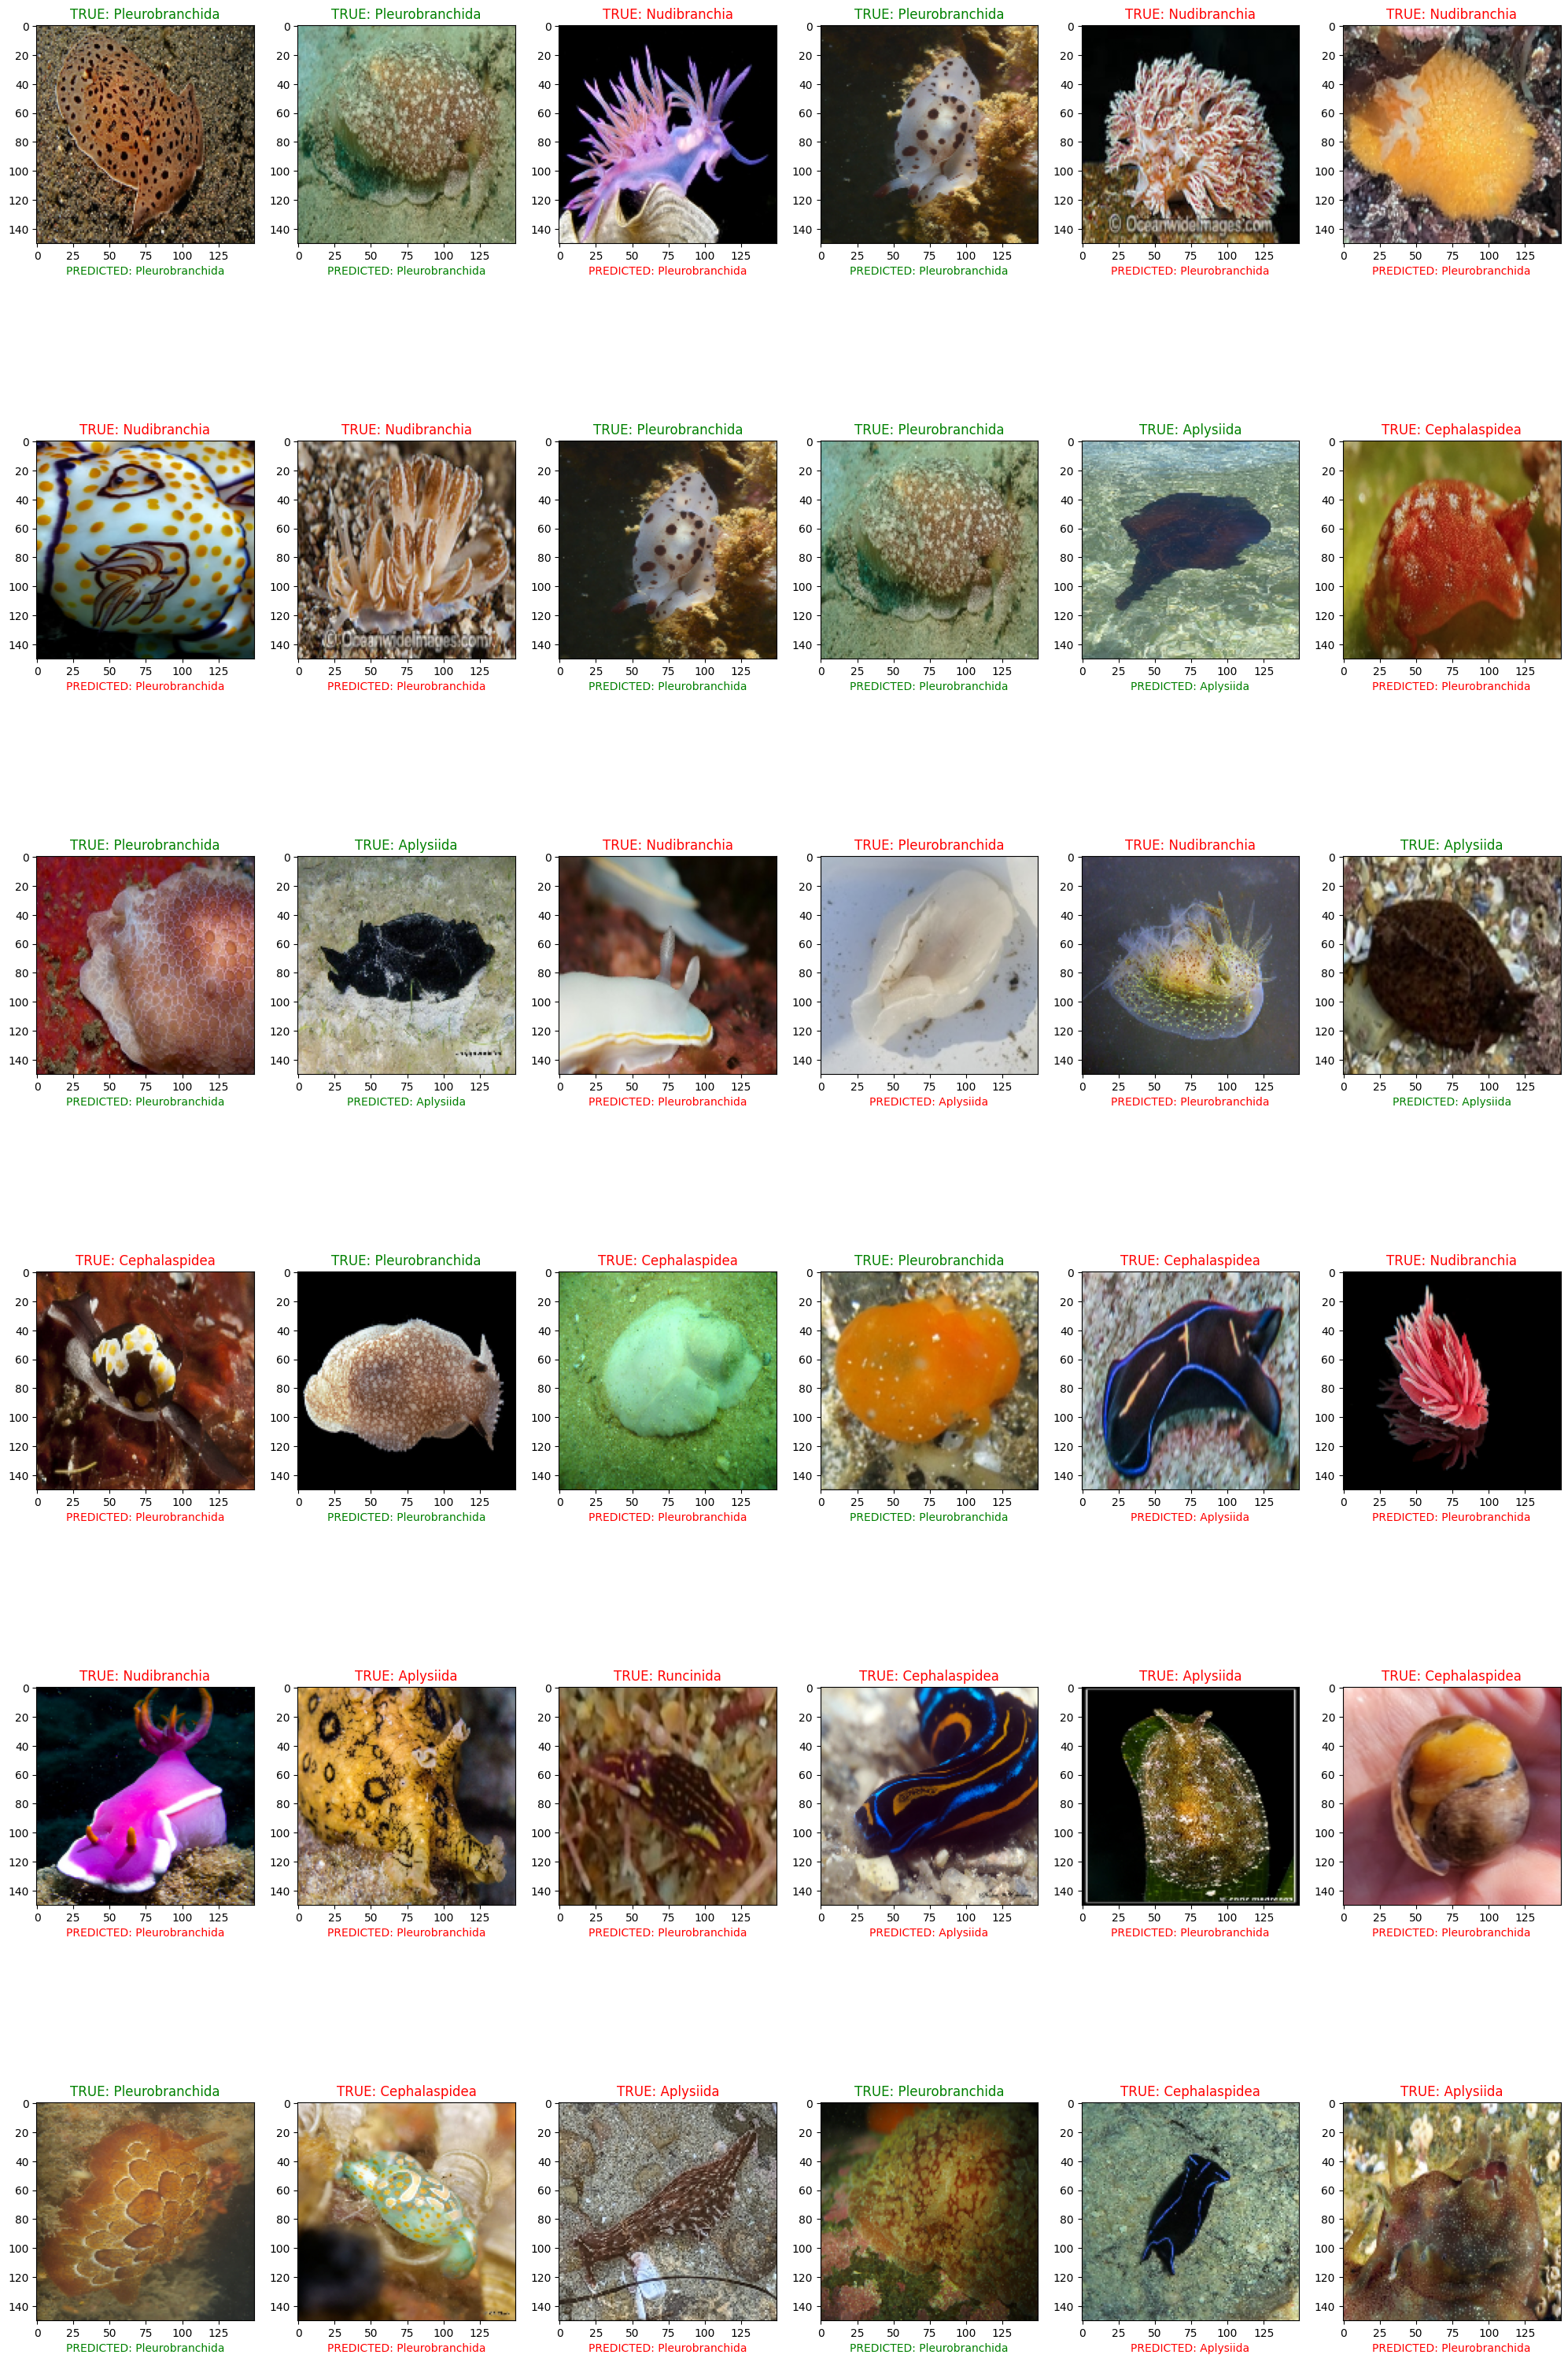

In [32]:
# set up 6x6 subplots 
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        # find class with largest predicted probability using argmax 
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
        # if the max probability of y_test[k] = max prob of X_test[k]: print true category above photo, as well as 
        # the predicted category in GREEN (because they are equal)
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray');
            
        else:
        # otherwise, print True categroy and the predicted category in RED 
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray');
            
            
            

## Saving the model

In [64]:
model1 = model.to_json()
with open("model1.json", "w") as json_file :
    json_file.write(model1)

model.save_weights("model.h5")

print("Saved model to disk")

model.save('CNN.model')


Saved model to disk


INFO:tensorflow:Assets written to: CNN.model/assets


INFO:tensorflow:Assets written to: CNN.model/assets


## Visualize loss/accuracy of model 

In [65]:


import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

## Attempting ResNet 

### trying again 

In [125]:
#from keras.applications import ResNet50
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [126]:
model = Sequential()
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model.add(ResNet50(include_top=False, pooling='avg', weights=None))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

model.layers[0].trainable = False

In [130]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
batch_size=32
epochs= 64

In [131]:
# Stop training when a monitored metric has stopped improving
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


In [133]:
history = model.fit_generator(gen_data.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              callbacks= [earlystopping],
                              verbose = 1)

Epoch 1/64


/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



29/29 [==============================] - 54s 2s/step - loss: 1.6627 - accuracy: 0.2905 - val_loss: 1.5944 - val_accuracy: 0.2124
Epoch 2/64
29/29 [==============================] - 47s 2s/step - loss: 1.5040 - accuracy: 0.3548 - val_loss: 1.5935 - val_accuracy: 0.2212
Epoch 3/64
29/29 [==============================] - 45s 2s/step - loss: 1.4371 - accuracy: 0.3925 - val_loss: 1.5872 - val_accuracy: 0.2832
Epoch 4/64
29/29 [==============================] - 44s 2s/step - loss: 1.4539 - accuracy: 0.3758 - val_loss: 1.6084 - val_accuracy: 0.2257
Epoch 5/64
29/29 [==============================] - 43s 1s/step - loss: 1.4207 - accuracy: 0.3825 - val_loss: 1.5969 - val_accuracy: 0.2080
Epoch 6/64
29/29 [==============================] - 42s 1s/step - loss: 1.3897 - accuracy: 0.4113 - val_loss: 1.5800 - val_accuracy: 0.2566
Epoch 7/64
29/29 [==============================] - 46s 2s/step - loss: 1.4048 - accuracy: 0.3947 - val_loss: 1.5714 - val_accuracy: 0.2301
Epoch 8/64
29/29 [=============

In [39]:
import tensorflow

In [55]:
X_test.shape

(597, 150, 150, 3)

In [53]:
X_test= X_test.reshape(224, 224, 3)

ValueError: cannot reshape array of size 40297500 into shape (224,224,3)

In [41]:
model = tensorflow.keras.models.load_model('model_ignore/VGG16_fine_tuning_2_no_augmentation')


In [47]:
score = model.evaluate(X_test, y_test, verbose=0)


ValueError: in user code:

    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/Ironhack/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)


In [ ]:
model.save_weights("model.h5")